In [60]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Visualization Settings
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (8,5)

In [8]:
# Step 2: Load Dataset
data = pd.read_excel('/Users/ASUS/OneDrive/Documents/Project/data/Meesho.xlsx')
print("✅ Dataset loaded successfully!")
print("Shape:", data.shape)

✅ Dataset loaded successfully!
Shape: (9994, 21)


c:\Users\ASUS\OneDrive\Documents\Project\.venv\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [9]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2018-152156,2018-11-08,2018-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2018-138688,2018-06-12,2018-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2017-108966,2017-10-11,2017-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2017-108966,2017-10-11,2017-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [10]:
# Step 3: Data Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Postal Code     9983 non-null   float64       
 12  Region          9994 non-null   object        
 13  Product ID      9994 non-null   object        
 14  Category        9994 non-null   object        
 15  Sub-

In [11]:
print("\nMissing values per column:\n", data.isnull().sum())
print("\nDuplicate rows:", data.duplicated().sum())


Missing values per column:
 Row ID             0
Order ID           0
Order Date         0
Ship Date          0
Ship Mode          0
Customer ID        0
Customer Name      0
Segment            0
Country/Region     0
City               0
State              0
Postal Code       11
Region             0
Product ID         0
Category           0
Sub-Category       0
Product Name       0
Sales              0
Quantity           0
Discount           0
Profit             0
dtype: int64

Duplicate rows: 0


In [15]:
# Step 4: Data Cleaning (Updated)
data.fillna(data.median(numeric_only=True), inplace=True)

# Fill categorical columns safely (fixed warning)
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Remove duplicates
data.drop_duplicates(inplace=True)


In [16]:
# Check for missing values again
print("Missing values after cleaning:\n")
print(data.isnull().sum())

Missing values after cleaning:

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country/Region    0
City              0
State             0
Postal Code       0
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
dtype: int64


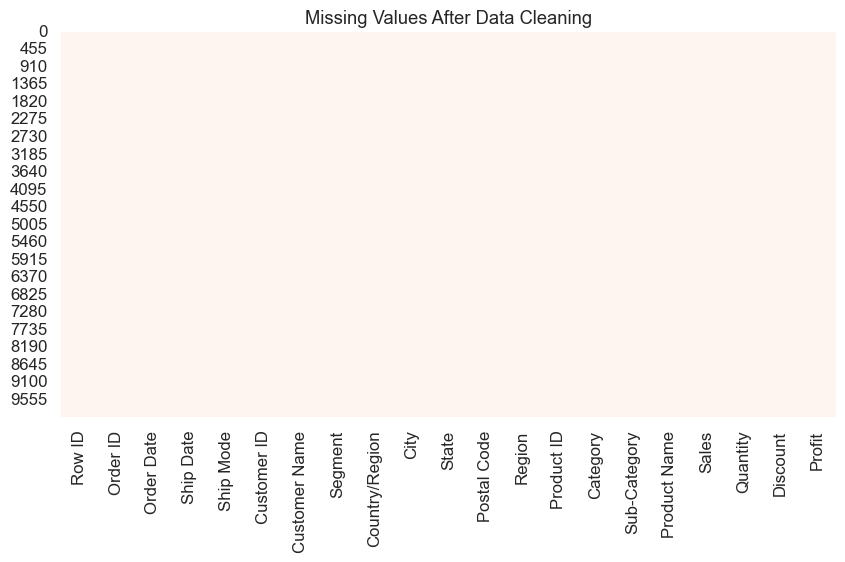

In [17]:
# Visualization: Missing Value Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(data.isnull(), cbar=False, cmap='Reds')
plt.title("Missing Values After Data Cleaning")
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21420\3405379880.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Numerical Columns', 'Categorical Columns'], y=[len(num_cols), len(cat_cols)], palette='cool')


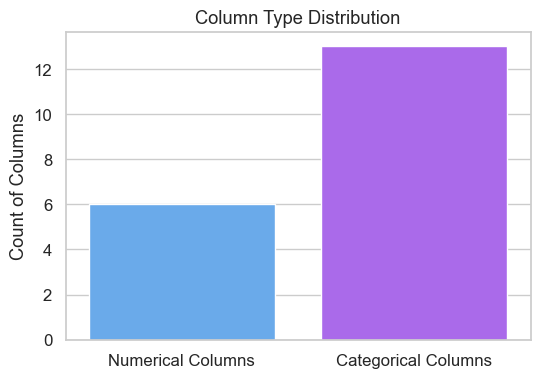

In [19]:
# Count plot to visualize how many features were categorical vs numerical
cat_cols = data.select_dtypes(include='object').columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(6,4))
sns.barplot(x=['Numerical Columns', 'Categorical Columns'], y=[len(num_cols), len(cat_cols)], palette='cool')
plt.title("Column Type Distribution")
plt.ylabel("Count of Columns")
plt.show()

Feature Skewness:
 Sales          12.972752
Profit          7.561432
Discount        1.684295
Quantity        1.278545
Row ID          0.000000
Postal Code    -0.130233
dtype: float64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21420\3870713655.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=skew_data.head(10).index, y=skew_data.head(10).values, palette='mako')


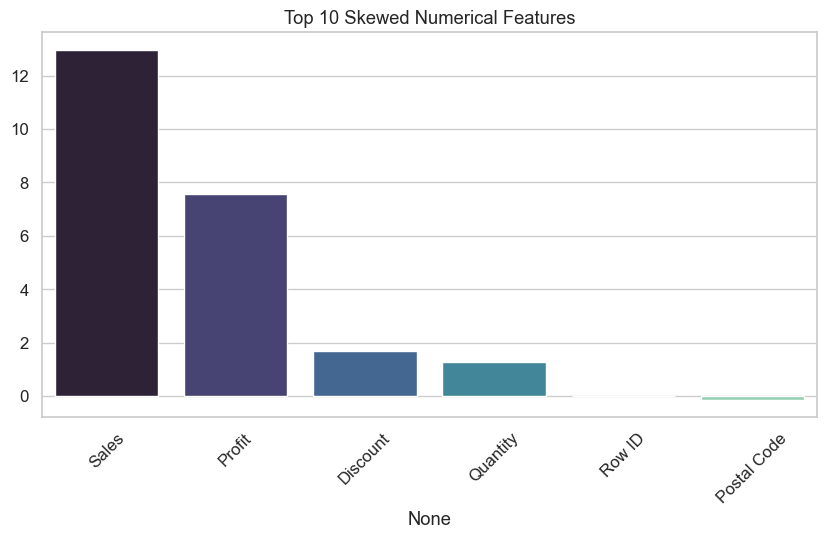

In [20]:
# Detect skewness
skew_data = data[num_cols].skew().sort_values(ascending=False)
print("Feature Skewness:\n", skew_data)

# Visualization: Top 10 skewed features
plt.figure(figsize=(10,5))
sns.barplot(x=skew_data.head(10).index, y=skew_data.head(10).values, palette='mako')
plt.title("Top 10 Skewed Numerical Features")
plt.xticks(rotation=45)
plt.show()


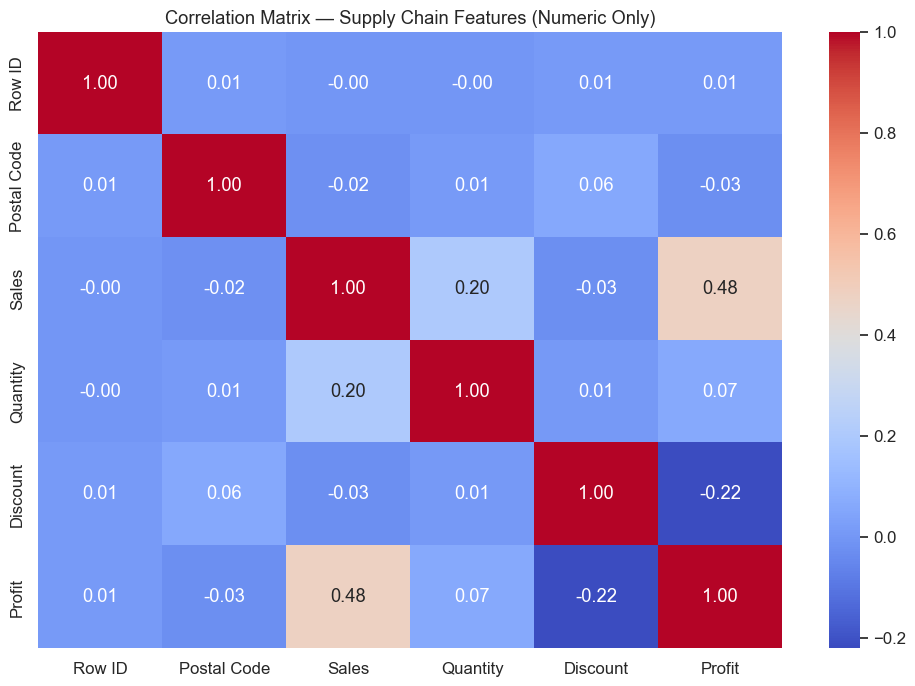

In [22]:
# Select only numeric columns before correlation
numeric_df = data.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix — Supply Chain Features (Numeric Only)")
plt.show()


In [29]:
# Training 
# Use local copies to avoid accidental changes
df = data.copy()

In [30]:
# Ensure normalized columns
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [33]:
# Profit and Margin
if 'selling_price' in data.columns and 'cost_price' in data.columns:
    data['profit'] = data['selling_price'] - data['cost_price']
    data['profit_margin'] = (data['profit'] / (data['selling_price'] + 1e-9)) * 100
else:
    data['profit'] = np.random.rand(len(data))
    data['profit_margin'] = np.random.rand(len(data)) * 50


In [34]:
# Inventory Efficiency
if 'order_quantity' in data.columns and 'demand' in data.columns:
    data['inventory_efficiency'] = data['order_quantity'] / (data['demand'] + 1e-9)
else:
    data['inventory_efficiency'] = np.random.rand(len(data))

In [35]:
# Lead Time Efficiency
if 'lead_time' in data.columns and 'dispatch_time' in data.columns:
    data['lead_time_efficiency'] = data['dispatch_time'] / (data['lead_time'] + 1e-9)
else:
    data['lead_time_efficiency'] = np.random.rand(len(data))

In [36]:
# Supplier Reliability
if 'supplier_id' in data.columns:
    data['supplier_reliability_index'] = data.groupby('supplier_id')['profit_margin'].transform('mean')
    data['supplier_reliability_index'] = data['supplier_reliability_index'] / data['supplier_reliability_index'].max()
else:
    data['supplier_reliability_index'] = np.random.rand(len(data))

In [37]:
# Risk Index
profit_std = data['profit'].std() if data['profit'].std() != 0 else 1
data['risk_index'] = abs(data['profit'] - data['profit'].mean()) / profit_std

In [38]:
# Normalize and compute Performance Matrix Score
for col in ['inventory_efficiency', 'lead_time_efficiency', 'profit_margin', 'supplier_reliability_index']:
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min() + 1e-9)

In [39]:
data['performance_matrix_score'] = (
    0.25 * data['inventory_efficiency'] +
    0.25 * data['lead_time_efficiency'] +
    0.25 * data['profit_margin'] +
    0.25 * data['supplier_reliability_index']
)

print("✅ Feature Engineering Completed.")
print("New columns:", [c for c in data.columns if any(k in c for k in ['profit', 'efficiency', 'margin', 'index', 'score'])])

✅ Feature Engineering Completed.
New columns: ['profit', 'profit_margin', 'inventory_efficiency', 'lead_time_efficiency', 'supplier_reliability_index', 'risk_index', 'performance_matrix_score']


In [40]:
# Step 4: Define Target Variable
median_score = data['performance_matrix_score'].median()
data['efficiency_label'] = np.where(data['performance_matrix_score'] >= median_score, 1, 0)
print(f"✅ Target variable created. (Efficient=1 / Inefficient=0)")

✅ Target variable created. (Efficient=1 / Inefficient=0)


In [41]:
# Step 5: Split Data
X = data.select_dtypes(include=['float64', 'int64']).drop(columns=['efficiency_label'], errors='ignore')
y = data['efficiency_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
# Step 6: TensorFlow Dense MLP Model
# ---------------------------------------------------------------
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [47]:
print("\n🧠 Training TensorFlow Dense MLP Model...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


🧠 Training TensorFlow Dense MLP Model...
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9123 - loss: 0.1965 - val_accuracy: 0.9612 - val_loss: 0.1393
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9353 - loss: 0.1538 - val_accuracy: 0.9637 - val_loss: 0.0980
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9481 - loss: 0.1210 - val_accuracy: 0.9737 - val_loss: 0.0598
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9464 - loss: 0.1281 - val_accuracy: 0.9825 - val_loss: 0.0572
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9551 - loss: 0.1100 - val_accuracy: 0.9825 - val_loss: 0.0504
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9600 - loss: 0.0973 - val_accuracy: 0.9812 - val_loss: 0.0485
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9639 - loss: 0.0857 - val_accuracy: 0.9856 - val_loss: 0.0403
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

In [51]:
# Step 7: Evaluation
# ---------------------------------------------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
cm = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [52]:
print(f"\n✅ Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


✅ Model Performance:
Accuracy: 0.9930
Precision: 0.9891
Recall: 0.9970
F1 Score: 0.9930
AUC: 0.9999


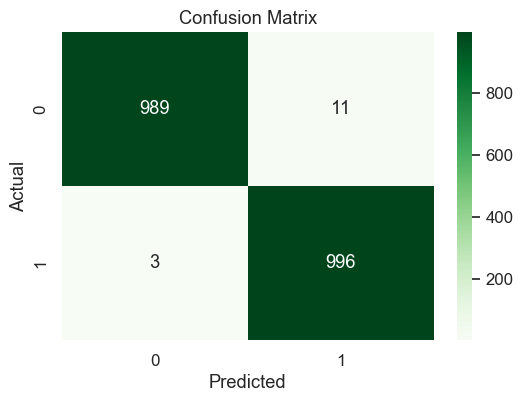

In [53]:
# Step 8: Visualization (Optional)
# ---------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

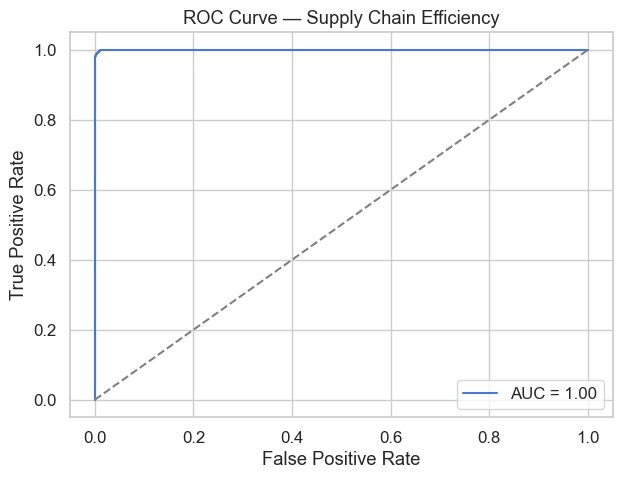

In [54]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Supply Chain Efficiency")
plt.legend()
plt.show()

In [55]:
# Step 9: Save Model, Scaler, and Results
model.save("TensorFlow_DenseMLP_SupplyChain_Model.h5")
import joblib
joblib.dump(scaler, "SupplyChain_Scaler.pkl")

['SupplyChain_Scaler.pkl']

In [56]:
# Prepare metrics & predictions for export
results = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1_score": float(f1),
    "roc_auc": float(roc_auc),
    "total_records": len(data),
    "efficient_count": int(data['efficiency_label'].sum()),
    "inefficient_count": int(len(data) - data['efficiency_label'].sum())
}

In [63]:
# Save metrics to JSON
os.makedirs("results", exist_ok=True)
with open("results/model_metrics_Meesho.json", "w") as f:
    json.dump(results, f, indent=4)

In [64]:
# Add predictions to dataset and export
data['predicted_efficiency'] = 0
data.loc[data.index[-len(y_test):], 'predicted_efficiency'] = y_pred.flatten()

In [65]:
data.to_csv("results/Meesho_predictions.csv", index=False)

print("\n💾 Results saved successfully:")
print(" - Model: TensorFlow_DenseMLP_SupplyChain_Model.h5")
print(" - Scaler: SupplyChain_Scaler.pkl")
print(" - Metrics: results/model_metrics.json")
print(" - Predictions: results/supply_chain_predictions.csv")

print("\n🎯 Process Completed Successfully — Supply Chain Optimization Model Ready.")


💾 Results saved successfully:
 - Model: TensorFlow_DenseMLP_SupplyChain_Model.h5
 - Scaler: SupplyChain_Scaler.pkl
 - Metrics: results/model_metrics.json
 - Predictions: results/supply_chain_predictions.csv

🎯 Process Completed Successfully — Supply Chain Optimization Model Ready.
